In [1]:
'''
Example of tensorflow(keras)-based distance driven 2d forward and backprojection
'''

'\nExample of tensorflow(keras)-based distance driven 2d forward and backprojection\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import tensorflow as tf
import os
import tensorflow.keras.backend as K

In [3]:
import ct_projector.projector.tensorflow as ct_projector_tf
import ct_projector.projector.tensorflow.circular_2d as ct_circular_tf

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
# load a sample CT image
filename = './3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

img = img[200:232]

# also convert to image to our projector dimension batch, z, y, x
img = img[::-1, ...]
spacing = np.array(spacing[::-1])

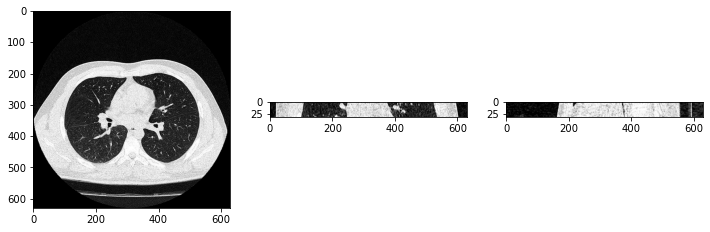

In [6]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[img.shape[0]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[:, img.shape[1]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[..., img.shape[2]//2], 'gray', aspect=spacing[0] / spacing[1])

The projector holds the default parameters for the forward and backprojection. 

However, all the projection parameters are passed during calculation to enable training with various geometry. The only constraint is that within one batch the input images must be of the same shape, otherwise they cannot be passed as tensors `[batch, nx, ny, nz, channel]`. The output images must also have the same shapes. 

In [7]:
# setup the projector
projector = ct_projector_tf.ct_projector()
projector.from_file('./projector_fan.cfg')
projector.nx = img.shape[2]
projector.ny = img.shape[1]
projector.nz = 1
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]
projector.nv = 1
projector.nview = 768

angles = projector.get_angles()

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 768
rotview = 720
nu = 736
nv = 1
nx = 630
ny = 630
nz = 1
dx = 0.6835939884185791
dy = 0.6835939884185791
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = -1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x7f5a51996d30>


In [13]:
img_input = img.transpose([0, 2, 1])[..., np.newaxis, np.newaxis]
print(img_input.shape)
fp = ct_circular_tf.distance_driven_2d_fp(
    projector,
    img_input,
    angles
).numpy()

(32, 630, 630, 1, 1)


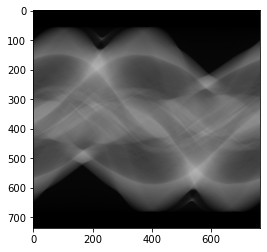

In [9]:
plt.imshow(fp[fp.shape[0] // 2, :, 0, :, 0], 'gray', vmin=0, vmax=10)

0.0


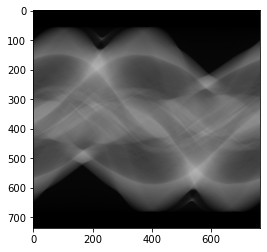

In [10]:
import cupy as cp
from ct_projector.projector.cupy.fan_equiangular import distance_driven_fp

cuimg = cp.array(img, order='C')[:, cp.newaxis, :, :]
cuangles = cp.array(angles, order='C')
cufp_ref = distance_driven_fp(projector, cuimg, cuangles)

fp_ref = cufp_ref.get()
fp_ref = fp_ref.transpose([0, 3, 2, 1])[..., np.newaxis]
plt.imshow(fp_ref[fp_ref.shape[0] // 2, :, 0, :, 0], 'gray', vmin=0, vmax=10)

print(np.abs(fp-fp_ref).max())